# 1. Import & Setting

### 1-1) import

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from pyarrow import csv
from matplotlib import pyplot as plt
from matplotlib import font_manager, rc
from sklearn.cluster import DBSCAN

import bus

### 1-2) plt font setting

In [2]:
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# 2. Def

### 2-1) 정류장 추출

In [3]:
def analyze_usage(usage_df):
    usage_df = usage_df[["geton_station_id", "user_count"]].groupby("geton_station_id").sum()
    usage_df.index.name = "geton_station_id"
    usage_df = usage_df.rename(columns={"user_count":"usage"})
    return usage_df

def create_station_df(usage_df):
    geton_station_columns = ['geton_station_id', 'geton_stataion_name', 'geton_station_longitude', 'geton_station_latitude']
    getoff_station_columns = ['getoff_station_id', 'getoff_station_name', 'getoff_station_longitude', 'getoff_station_latitude']
    
    station_columns = ['station_id', 'station_name', 'station_longitude', 'station_latitude']
    
    geton_rename_dict = {}
    getoff_rename_dict = {}
    for i, column in enumerate(station_columns):
        geton_rename_dict[geton_station_columns[i]] = column
        getoff_rename_dict[getoff_station_columns[i]] = column
    
    geton_station_df = usage_df[geton_station_columns].drop_duplicates().rename(columns = geton_rename_dict)
    getoff_station_df = usage_df[getoff_station_columns].drop_duplicates().rename(columns = getoff_rename_dict)
    
    station_df = pd.concat([geton_station_df, getoff_station_df]).drop_duplicates()
    print(len(station_df[['station_id']]))
    station_id_df = station_df[['station_id']].drop_duplicates()
    print(len(station_id_df))
    station_df = pd.merge(station_id_df, station_df, how ='right')
    
    station_df = station_df.dropna()
    
    # 예외처리 - 하나의 id에 대하여 여러 경도, 위도 존재
    id_count_df = pd.DataFrame(station_df['station_id'].value_counts()).reset_index().rename(columns = {'index':'station_id', 'station_id':'count'})
    exception_df = id_count_df[id_count_df['count'] >1]
    exception_id_list = list(exception_df['station_id'])
    for exception_id in exception_id_list:
        temp_df = station_df[station_df['station_id'] == exception_id]
        station_df = station_df[station_df['station_id'] != exception_id]
        station_df = pd.concat([station_df, temp_df.head(1)])
    ######################################################################                            
    return station_df

### 2-2) 정류장 주소 추가

In [4]:
import xml.etree.ElementTree as elemTree
import requests

def set_address_column(df):
    df = pd.DataFrame.copy(df)
    df["station_address"] = ""
    for i in tqdm(df.index):
        df.loc[i, "station_address"] = get_address(float(df.loc[i, "station_longitude"]), float(df.loc[i, "station_latitude"]))
    return df

def get_address(loc_x, loc_y, min_x = 126.531891, min_y = 33.399409, key = "E20F6493-C13D-3F6F-AC90-D5BB2F239901"):
    loc_x = round(float(loc_x), 7)
    loc_y = round(float(loc_y), 7)
    url_form = "http://api.vworld.kr/req/address?service=address&request=getAddress&version=2.0&crs=epsg:4326&point={},{}&format=xml&type=both&zipcode=true&simple=false&key={}"
    url = url_form.format(loc_x, loc_y, key)
    response = requests.get(url)
    tree = elemTree.fromstring(response.text)
    branch = ""
    try:
#     road = tree.find("result").find("item[2]").find("text").text
        branch = tree.find("result").find("item[1]").find("text").text
    except:
#         print("현재 좌표: ",(loc_x, loc_y), "주소 없음")
        x_left = str(int(loc_x))
        y_left = str(int(loc_y))
        
        
        if min_x < loc_x:
            x_right = str((int(loc_x*100000)-2)%100000)
        else:
            x_right = str((int(loc_x*100000)+2)%100000)
            
        if min_y < loc_y:
            y_right = str((int(loc_y*100000)-2)%100000)
        else:
            y_right = str((int(loc_y*100000)+2)%100000)
            
        loc_x = float(x_left+"."+x_right)
        loc_y = float(y_left+"."+y_right)
        return get_address(loc_x, loc_y)
            
    return branch

### 2-3) 이용자 추출

In [129]:
def create_user_df(usage_df):    # 유저 목록 생성
    return usage_df[["user_id"]].drop_duplicates()

# 이용기간 및 이용 날짜 분석
def analyze_usage_date(usage_df, user_df):
    grouped = usage_df[["user_id", "base_date"]].drop_duplicates().groupby(by=["user_id"], as_index=False)
    first_date_df = grouped.min().rename(columns = {"base_date" : "first_date"})
    last_date_df = grouped.max().rename(columns = {"base_date" : "last_date"})
    use_days_df= grouped.count().rename(columns = {"base_date" : "use_days"})
    user_df = pd.merge(user_df, first_date_df, on="user_id")
    user_df = pd.merge(user_df, last_date_df, on="user_id")
    user_df = pd.merge(user_df, use_days_df, on="user_id")
    user_df['first_date'] = user_df['first_date'].apply(lambda x : datetime.datetime.strptime(str(x), "%Y%m%d").date()) 
    user_df['last_date'] = user_df['last_date'].apply(lambda x : datetime.datetime.strptime(str(x), "%Y%m%d").date())
    user_df["period"] = user_df["last_date"] - user_df["first_date"]
    user_df["period"] = user_df["period"].apply(lambda x : int(str(x).split(" ")[0])+1)
    return user_df

# 버스 이용량 분석
def analyze_usage_num(usage_df, user_df):
    grouped = usage_df[["user_id", "base_date"]].groupby(by=["user_id"], as_index=False)
    count_df = grouped.count().rename(columns = {"base_date" : "usage"})
    user_df = pd.merge(user_df, count_df, on="user_id")
    return user_df

# 이용 비율 분석(%)
def analyze_usage_ratio(user_df):
    user_df['usage_ratio'] = user_df['use_days'].apply(lambda x : float(x))
    user_df['usage_ratio'] = user_df['usage_ratio']/user_df["period"]
    user_df['usage_ratio'] = user_df['usage_ratio'].apply(lambda x : int(x*100))
    return user_df

# 첫 승차 정류장과 마지막 하차 정류장 분석
def analyze_start_end(usage_df, user_df):
    grouped = usage_df.sort_values(['geton_datetime']).groupby(by=["user_id"], as_index=False)
    first = grouped.first()
    last = grouped.last()
    first['first_station'] = first['geton_stataion_name'].apply(lambda x : "airport" if str(x).find("공항") != -1 else "harbor" if (
                                                             bool(str(x).find("여객터미널") != -1)| 
                                                             bool(str(x).find("여객선")     != -1)|
                                                             bool(str(x).find("제6부두")    != -1)|
                                                             bool(str(x).find("제4부두")    != -1)|
                                                             bool(str(x).find("임항로")     != -1)|
                                                             bool(str(x).find("제주해양경찰서") != -1)) else "other")
    last['last_station'] = last['getoff_station_name'].apply(lambda x : "airport" if str(x).find("공항") != -1 else "harbor" if (
                                                             bool(str(x).find("여객터미널") != -1)| 
                                                             bool(str(x).find("여객선")     != -1)|
                                                             bool(str(x).find("제6부두")    != -1)|
                                                             bool(str(x).find("제4부두")    != -1)|
                                                             bool(str(x).find("임항로")     != -1)|
                                                             bool(str(x).find("제주해양경찰서")!= -1))  else "other")
    first2 = first[["user_id", "first_station"]]
    last2 = last[["user_id", "last_station"]]
    flag_df = pd.merge(first2, last2, on = "user_id")
    flag_df["both"] = (flag_df["first_station"]!='other') & (flag_df["last_station"]!='other')
    flag_df["first"] = (flag_df["first_station"]!='other') & (flag_df["last_station"]=='other')
    flag_df["last"] = (flag_df["first_station"]=='other') & (flag_df["last_station"]!='other')
    flag_df["neither"] = (flag_df["first_station"]=='other') & (flag_df["last_station"]=='other')
    flag_df = flag_df.reset_index()
    flag_df = flag_df[['user_id', 'first_station', 'last_station', 'both', 'first', 'last', 'neither']]
    user_df = pd.merge(user_df, flag_df)
    return user_df

### 2-4) 관광객 추출

In [321]:
def extract_used_station(user_df, usage_df, station_df, case):
    user_df = user_df[user_df[case] == True]
    user_list = list(user_df['user_id'])
    usage_df = usage_df.query('{} in {}'.format("user_id", user_list))
    geton_station = pd.DataFrame(usage_df['geton_station_id'].value_counts()).reset_index().rename( columns = {'index':'station_id', 'geton_station_id': 'geton_usage'} )
    getoff_station = pd.DataFrame(usage_df['getoff_station_id'].value_counts()).reset_index().rename( columns = {'index':'station_id', 'getoff_station_id': 'getoff_usage'} )
    
    station_df = pd.merge(station_df, geton_station, on='station_id')
    station_df = pd.merge(station_df, getoff_station, on='station_id')
    
    station_df['total_usage'] = station_df['geton_usage'] + station_df['getoff_usage']
    
    return station_df

# case1~2에서 추출한 관광 관련 정류장 방문 횟수 분석
def analyze_tour_station_visit(user_df, usage_df, tour_station_df):
    # 기존에 해당 컬럼이 존재한다면 삭제
    if "tour_visit" in user_df.columns:
        del user_df["tour_visit"]
    
    tour_station_df = tour_station_df[tour_station_df['tour_station'] == True]
    tour_station_df = tour_station_df[tour_station_df['total_usage'] >= 150]
    tour_station_id_list = list(tour_station_df['station_id'])

    usage_df = usage_df[usage_df["geton_station_id"].apply(lambda x : True if x in tour_station_id_list else False)]
    usage_df = usage_df[usage_df["getoff_station_id"].apply(lambda x : True if x in tour_station_id_list else False)]

    geton_visit_df = usage_df[['user_id', 'geton_station_id']].rename(columns = {"geton_station_id":"tour_visit"})
    getoff_visit_df = usage_df[['user_id', 'getoff_station_id']].rename(columns = {"getoff_station_id":"tour_visit"})

    tour_visit_df = pd.concat([geton_visit_df, getoff_visit_df]).drop_duplicates()
    tour_visit_df = tour_visit_df.groupby(by="user_id").count()

    user_df = pd.merge(user_df, tour_visit_df[["tour_visit"]], on="user_id", how="outer").fillna(0)
    return user_df

def analyze_case(user_df):
    cases = []
    
    # 공항 이용 유형 고려
    both = user_df[user_df["both"]]
    first = user_df[user_df["first"]]
    last = user_df[user_df["last"]]
    neither = user_df[user_df["neither"]]
    
    # 관광 정류장 방문횟수 고려
    cases.append(both[both["tour_visit"] >= 3])
    cases.append(both[both["tour_visit"] <  3])
    
    cases.append(first[first["tour_visit"] >= 5])
    cases.append(first[first["tour_visit"] <  5])
    
    cases.append(last[last["tour_visit"] >= 5])
    cases.append(last[last["tour_visit"] <  5])
    
    cases.append(neither[neither["tour_visit"] >= 7])
    cases.append(neither[neither["tour_visit"] <  7])
    
    for i in range(0, 8):
        cases[i]["case"] = i+1
    
    user_df = pd.concat(cases)
    return user_df

def extract_tourist(user_df, case, period, usage_ratio):
    select = user_df.columns
    
    # 케이스 추출
    user_df = user_df[user_df["case"] == case]
    # 이용 기간 고려
    user_df = user_df[(period[0] <= user_df["period"]) & (user_df["period"] <= period[1])]
    # 이용 비율 고려
    user_df = user_df[user_df['usage_ratio'] >= usage_ratio]
    return user_df

def analyze_tourist(user_df):
    tourist_df_list = []
    tourist_df_list.append(extract_tourist(user_df, 1, (2, 15), 90))
    tourist_df_list.append(extract_tourist(user_df, 2, (2, 15), 90))
    tourist_df_list.append(extract_tourist(user_df, 3, (2, 15), 90))
    tourist_df_list.append(extract_tourist(user_df, 5, (2, 15), 90))
    tourist_df_list.append(extract_tourist(user_df, 7, (2, 15), 90))
    tourist_df = pd.concat(tourist_df_list)
    return tourist_df

### 2-5) 시각화

# 3. main

### 3-1) - 이용데이터 로딩

In [9]:
start_date = datetime.datetime(2019, 6, 1)
end_date = datetime.datetime(2019, 8, 29)

input_path_list = bus.make_input_path(start_date, end_date)

usage_df = bus.load_total_usage_data(input_path_list)

100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [04:24<00:00,  2.98s/it]


### 3-2) - 정류장 추출

In [10]:
#정류장 추출
station_df = create_station_df(usage_df)
print("추출된 정류장 개수: ",len(station_df))

# 주소 컬럼 추가
station_df = set_address_column(station_df)

# sorting
station_df = station_df.sort_values(by="station_id")

# storing
station_df.to_csv("data/station_list.csv", encoding="CP949", index=False)

  0%|                                                                                 | 1/3654 [00:00<06:15,  9.74it/s]

3662
3656
추출된 정류장 개수:  3654


100%|██████████████████████████████████████████████████████████████████████████████| 3654/3654 [04:50<00:00, 12.59it/s]


### 3-3) - 이용자 추출 및 분석

In [115]:
user_df = create_user_df(usage_df)
print("유저 목록 생성")
user_df = analyze_usage_date(usage_df, user_df)
print("이용 날짜 분석 완료")
user_df = analyze_usage_num(usage_df, user_df)
print("이용 횟수 분석 완료")
user_df = analyze_usage_ratio(user_df)
print("이용 비율 분석 완료")
user_df = analyze_start_end(usage_df, user_df)
print("출발, 도작지 분석 완료")

유저 목록 생성
이용 날짜 분석 완료
이용 횟수 분석 완료
이용 비율 분석 완료
출발, 도작지 분석 완료


### 3-4) 관광객 추출

In [325]:
# case1, 2의 사용 정류장 추출 및 저장
both_station_df = extract_used_station(user_df, usage_df, station_df, 'both')
both_station_df.to_csv("data/case1_2.csv", encoding="cp949", index=False)
# HAND WORK - "data/case1_2.csv"를 보고 직접 관광 관련 정류장 컬럼을 삽입하고 "data/case1_2_filtered.csv"로 저장
tour_station_df = pd.read_csv("data/case1_2_filtered.csv", low_memory=False, encoding = "utf-8") #, dtype=dtype)

# 관광관련 정류장 방문 횟수 분석
user_df = analyze_tour_station_visit(user_df, usage_df, tour_station_df)

# 이용자 케이스 분류
user_df = analyze_case(user_df)

# 관광객 케이스 추출
tourist_df = analyze_tourist(user_df)

<ipython-input-321-eb0680944dd9>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cases[i]["case"] = i+1


### 3-5) 알고리즘 검증 - case검증

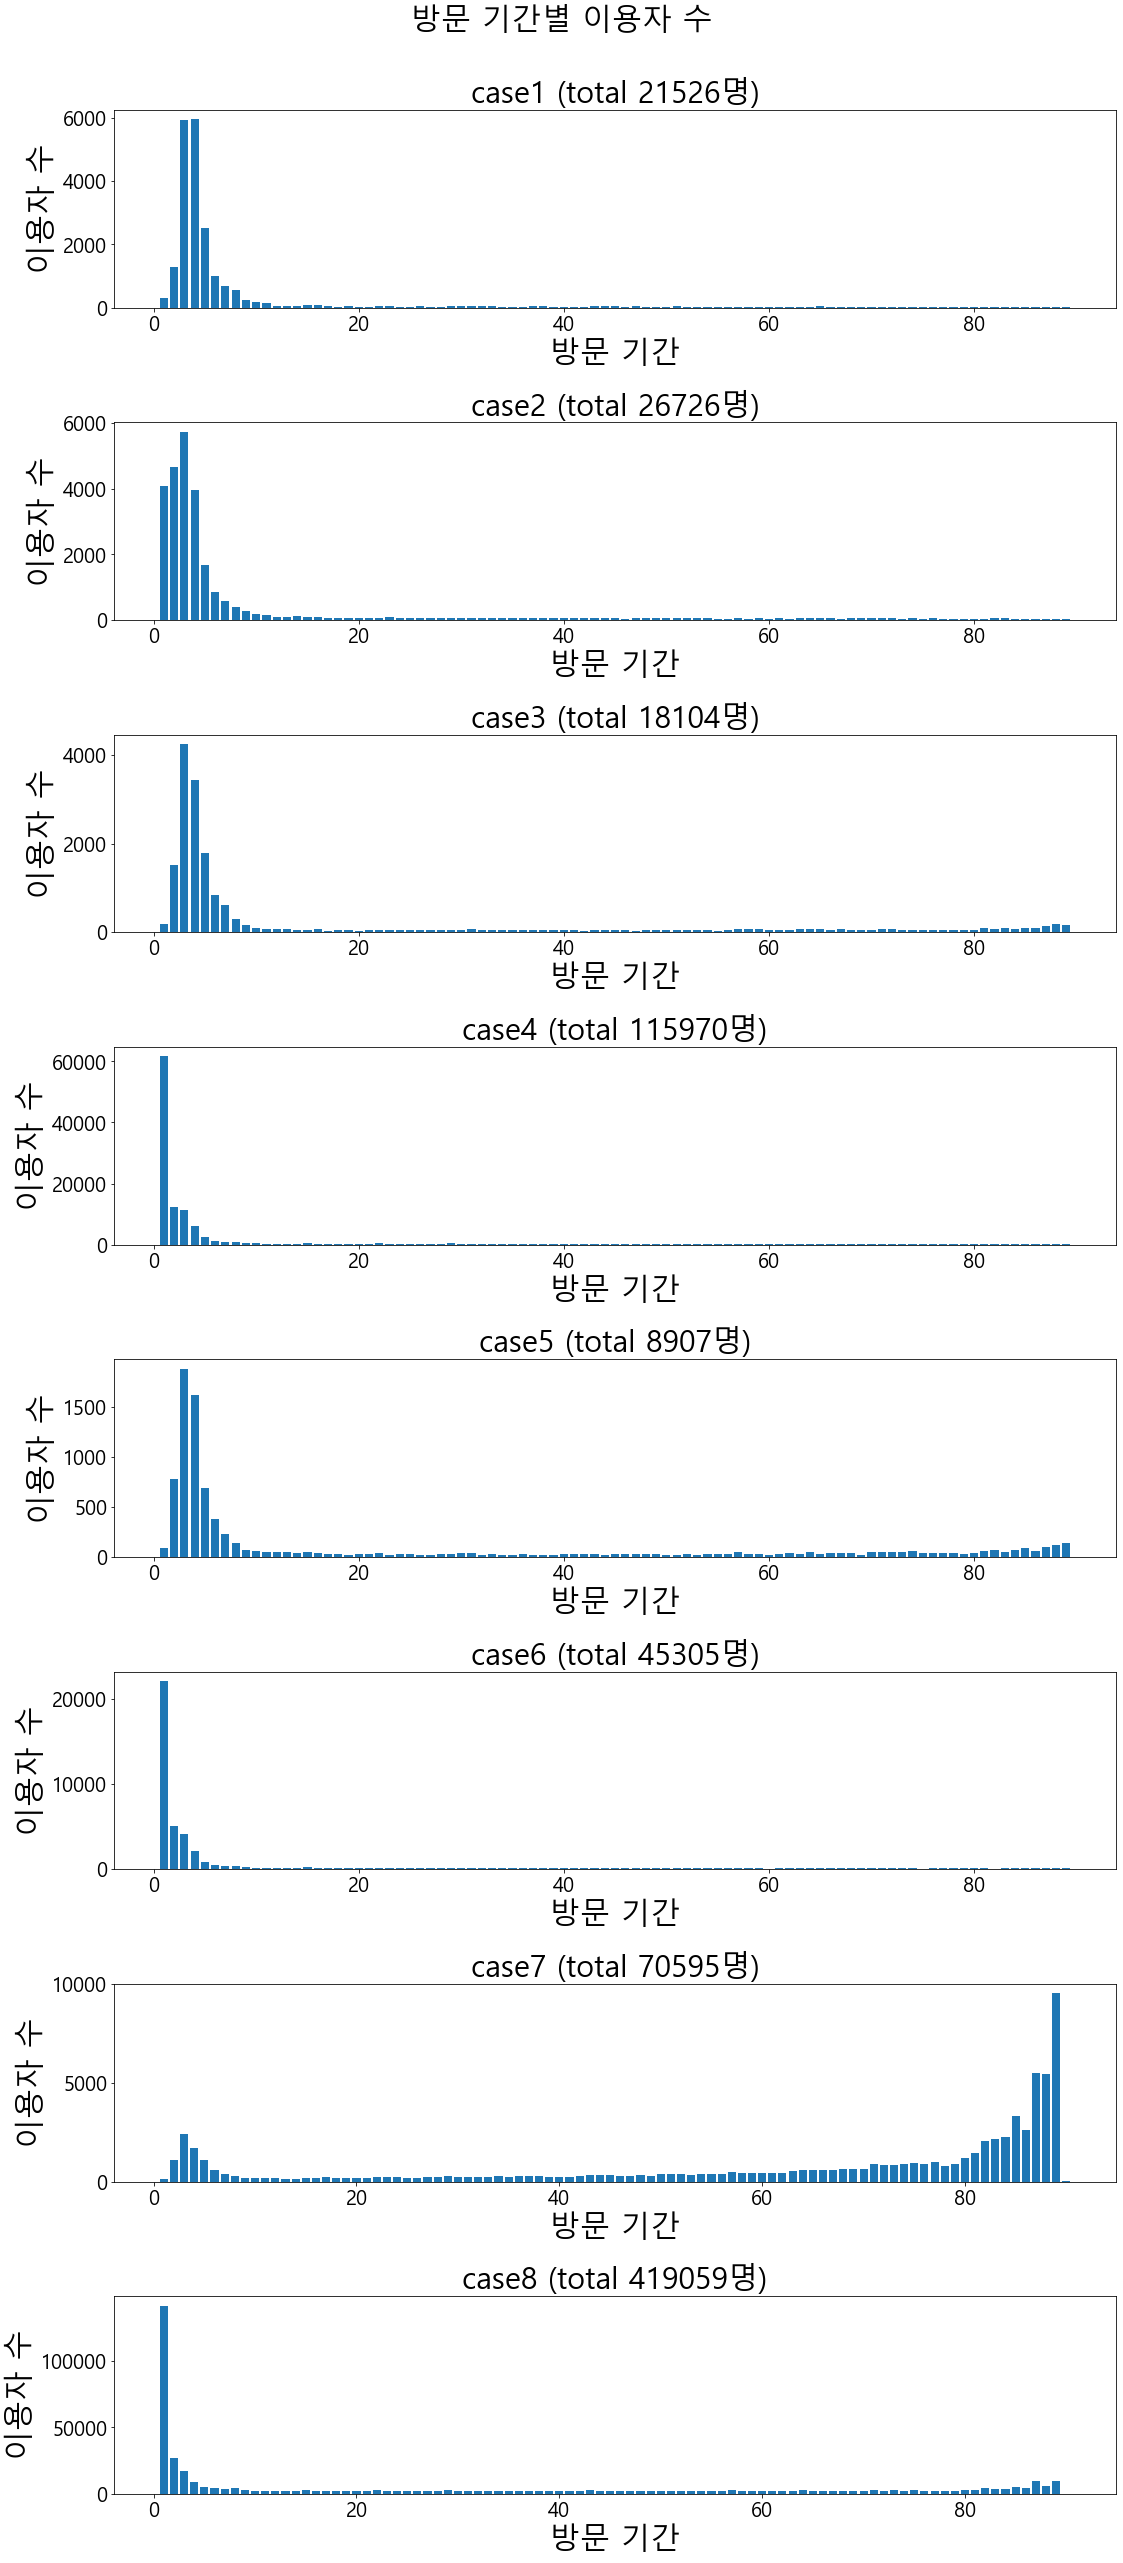

In [251]:
def draw_period_user(plt, user_df, title=""):
    data = user_df['period'].value_counts().reset_index().sort_values('index')
    data_x = data['index']
    data_y = data['period']
    
    plt.bar(data_x, data_y)
    if title == "":
        plt.title('방문 기간별 이용자 수', fontsize=30)
    else:
        plt.title(title, fontsize=30)
    plt.xlabel('방문 기간', fontsize = 30)
    plt.ylabel('이용자 수', fontsize = 30)
    return plt

def draw_period_user_per_case(user_df):
    plt.figure(figsize=(16, 35))

    for i in range(8):
        plt.subplot(8, 1, 1+i)
        case_df = user_df[user_df["case"] == 1+i]
        title = "case{} (total {}명)".format(1+i, len(case_df))
        draw_period_user(plt, case_df, title=title)
    plt.suptitle("방문 기간별 이용자 수", fontsize=30, y = 1.02)
    plt.tight_layout()  
    plt.show()
    
# 방문 기간 별 이용자 수 per each case
draw_period_user_per_case(user_df)

### 3-6) 알고리즘 검증 - usage_ratio검증

   both 이용자수 = ( 90%미만:  22853명,  90%이상:  25399명)
  first 이용자수 = ( 90%미만:  40955명,  90%이상:  93119명)
   last 이용자수 = ( 90%미만:  18913명,  90%이상:  35299명)
neither 이용자수 = ( 90%미만: 300097명,  90%이상: 189557명)


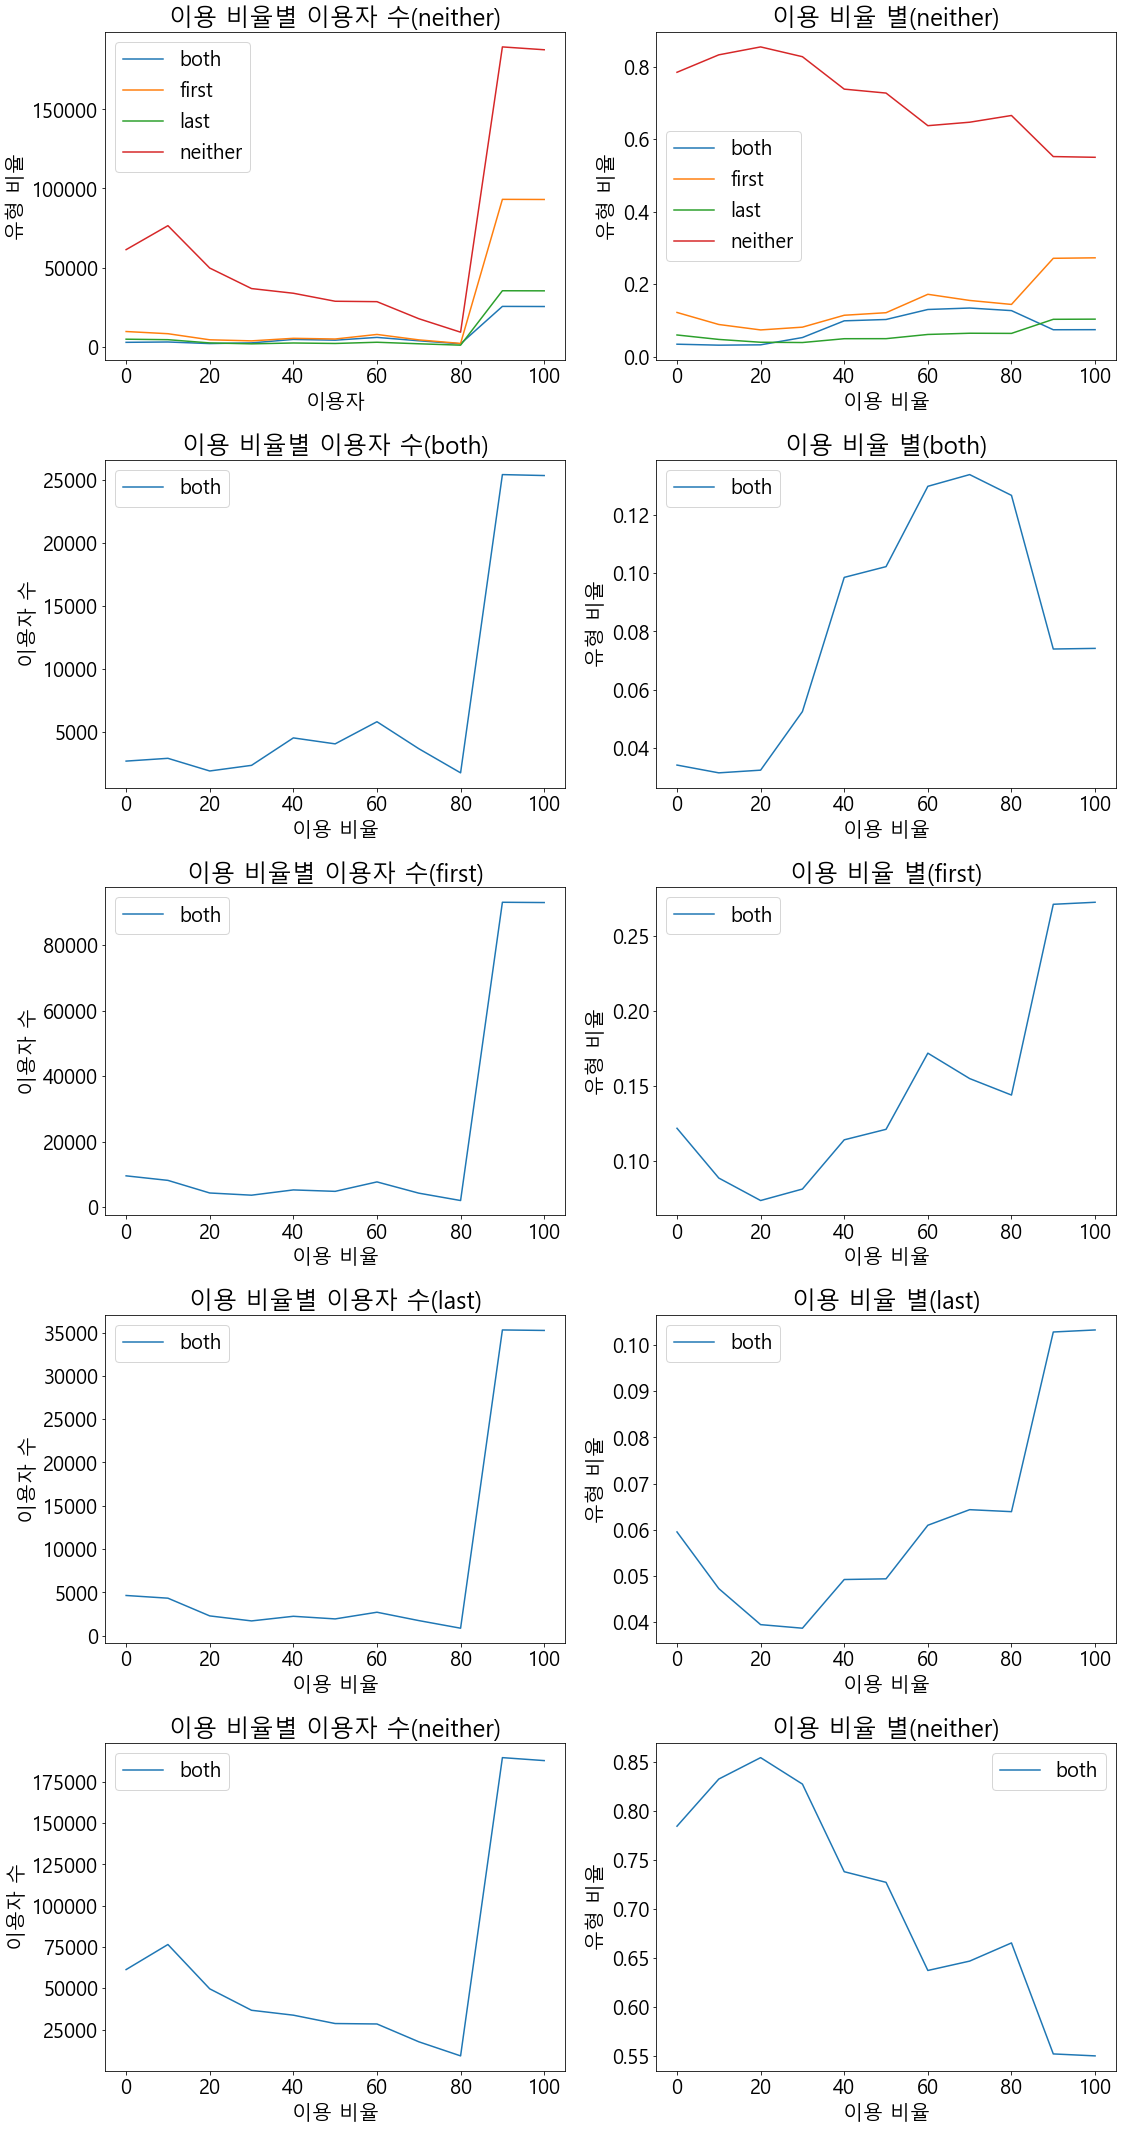

In [395]:
def draw_usage_ratio_analysis_graph(user_df):
    # 데이터 분석
    columns = ['both', 'first', 'last', 'neither']
    ratio_values = {}
    count_values = {}
    for column in columns:
        count_values[column] = []
        ratio_values[column] = []
    
    window_size = 10
    for i in range(0, 101, window_size):
        sample_df = user_df[(i <=user_df["usage_ratio"]) & (user_df["usage_ratio"] <= i+window_size)]
        total_count = len(sample_df)
        for column in columns:
            count = len(sample_df[sample_df[column] == True])
            count_values[column].append(count)
            ratio_values[column].append(count/total_count)
    
    #그래프 그리기
    plt.figure(figsize=(16, 30))
    
    #그래프 - 전체 그래프
    plt.subplot(5, 2, 1)
    for column in columns:
        plt.plot(list(range(0, 101, window_size)), count_values[column])
    plt.legend(columns, loc = 0)
    plt.title('이용 비율별 이용자 수({})'.format(column))
    plt.xlabel("이용자")
    plt.ylabel("유형 비율")

    plt.subplot(5, 2, 2)
    for column in columns:
        plt.plot(list(range(0, 101, window_size)), ratio_values[column])
    plt.legend(columns, loc = 0)
    plt.title('이용 비율 별({})'.format(column))
    plt.xlabel("이용 비율")
    plt.ylabel("유형 비율")
    
    #그래프 - 유형별 그래프
    for idx, column in enumerate(columns):
        plt.subplot(5, 2, 2*idx+3)
        plt.plot(list(range(0, 101, window_size)), count_values[column])
        plt.legend(columns, loc = 0)
        plt.title('이용 비율별 이용자 수({})'.format(column))
        plt.xlabel("이용 비율")
        plt.ylabel("이용자 수")

        plt.subplot(5, 2, 2*idx+4)
        plt.plot(list(range(0, 101, window_size)), ratio_values[column])
        plt.legend(columns, loc = 0)
        plt.title('이용 비율 별({})'.format(column))
        plt.xlabel("이용 비율")
        plt.ylabel("유형 비율")
    plt.tight_layout() 
    return plt
    


columns = ['both', 'first', 'last', 'neither']
boundary = 90
for column in columns:
    down = len(user_df[(user_df[column] == True) & (user_df["usage_ratio"] < boundary)])
    up = len(user_df[(user_df[column] == True) & (user_df["usage_ratio"] >= boundary)])
    print("%7s 이용자수 = (%3d%%미만: %6d명, %3d%%이상: %6d명)" % (column, boundary, down, boundary, up))
plt = draw_usage_ratio_analysis_graph(user_df)
plt.show()

In [361]:
temp_df = user_df[user_df["neither"] == True][user_df["period"]<14][user_df["period"]>=2][user_df["tour_visit"]>=10]
show_od_pattern(temp_df, usage_df, 8)

<ipython-input-361-88ad1d53b20d>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_df = user_df[user_df["neither"] == True][user_df["period"]<14][user_df["period"]>=2][user_df["tour_visit"]>=10]


,base_date,geton_datetime,geton_stataion_name,getoff_datetime,getoff_station_name,user_count
1652509,20190612,2019-06-12 16:52:21,서문시장,2019-06-12 16:59:21,광양,1
1652508,20190612,2019-06-12 17:14:34,제주시청(아라방면),2019-06-12 18:17:07,고성리제주은행,1
1799659,20190613,2019-06-13 07:15:56,고성리제주은행,NaT,NaN,1
1799660,20190613,2019-06-13 16:06:31,성산항,2019-06-13 16:18:34,성산포수협,1
2011235,20190614,2019-06-14 14:20:27,오조해녀의집,2019-06-14 14:56:52,표선환승정류장(표선리제주은행),1
2011234,20190614,2019-06-14 15:09:14,표선환승정류장(표선면사무소),2019-06-14 15:34:48,표선면충혼묘지,1
2011236,20190614,2019-06-14 16:40:17,표선면충혼묘지,2019-06-14 16:47:48,성읍농협앞,1
2011238,20190614,2019-06-14 18:33:11,성읍농협앞,2019-06-14 18:44:15,표선환승정류장(표선면사무소),1
2011237,20190614,2019-06-14 19:09:05,표선초등학교,2019-06-14 19:28:59,고성리제주은행,1
2096042,20190615,2019-06-15 11:17:33,고성리제주은행,2019-06-15 12:23:41,함덕환승정류장(함덕해수욕장),1


### 3-7) 알고리즘 검증 - tour_visit검증

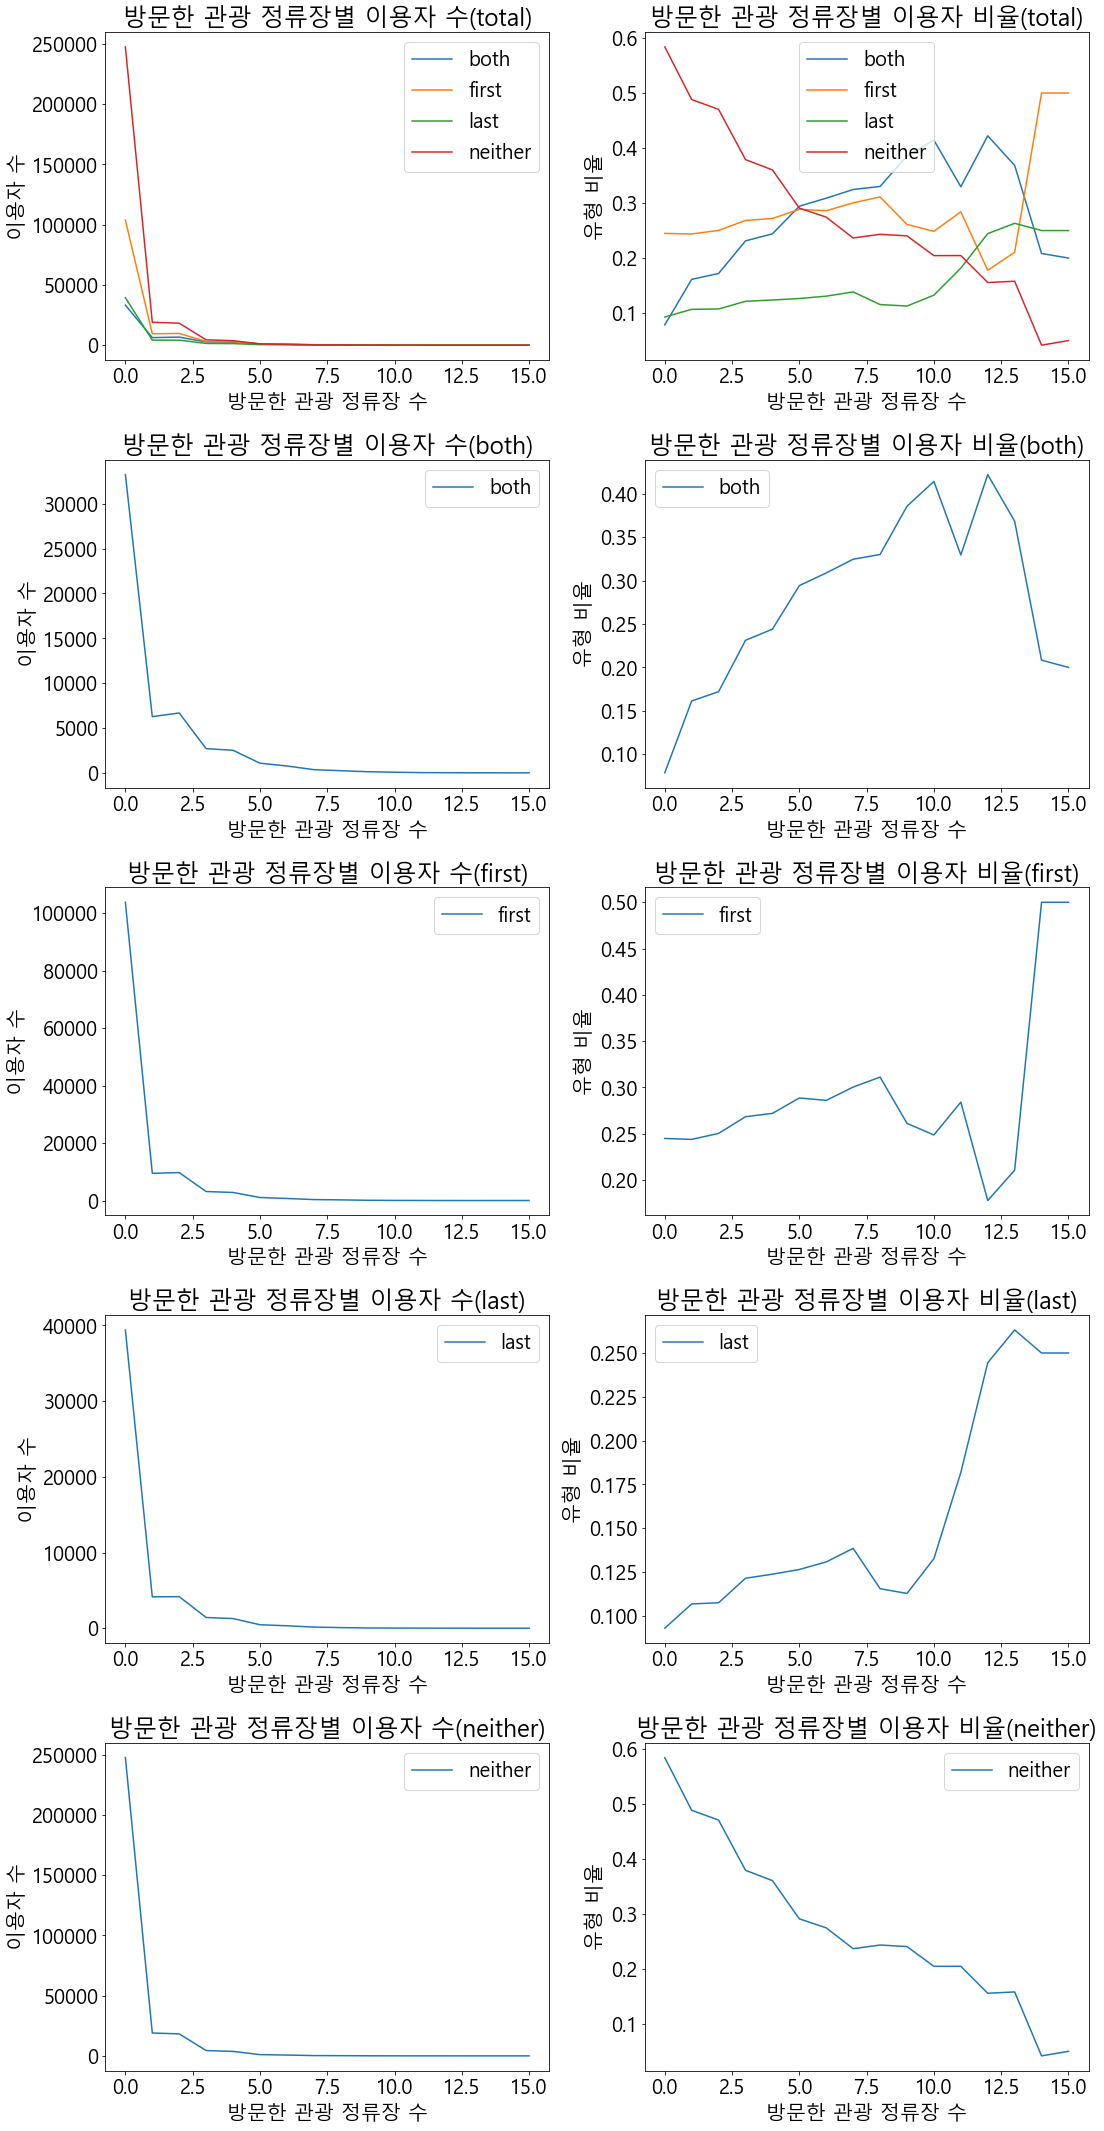

In [383]:
def draw_tour_visit_analysis_graph(user_df):
    # 데이터 분석
    columns = ['both', 'first', 'last', 'neither']
    ratio_values = {}
    count_values = {}
    for column in columns:
        count_values[column] = []
        ratio_values[column] = []

    max_visit = int(user_df["tour_visit"].max())
    for i in range(max_visit):
        sample_df = user_df[(i <=user_df["tour_visit"]) & (user_df["tour_visit"] <= i+1)]
        total_count = len(sample_df)
        for column in columns:
            count = len(sample_df[sample_df[column] == True])
            count_values[column].append(count)
            ratio_values[column].append(count/total_count)
    
    # 그래프 그리기
    plt.figure(figsize=(16, 30))
    
    # 그래프 - 전체 그래프
    plt.subplot(5, 2, 1)
    for idx, column in enumerate(columns):
        plt.plot(list(range(0, max_visit, 1)), count_values[column])
        plt.legend(columns, loc = 0)
        plt.title('방문한 관광 정류장별 이용자 수({})'.format("total"))
        plt.xlabel("방문한 관광 정류장 수")
        plt.ylabel("이용자 수") 
        
    # 그래프 - 유형별 그래프
    plt.subplot(5, 2, 2)
    for idx, column in enumerate(columns):
        plt.plot(list(range(0, max_visit, 1)), ratio_values[column])
        plt.legend(columns, loc = 0)
        plt.title('방문한 관광 정류장별 이용자 비율({})'.format("total"))
        plt.xlabel("방문한 관광 정류장 수")
        plt.ylabel("유형 비율")
        
    for idx, column in enumerate(columns):
        
        plt.subplot(5, 2, 2*(idx)+3)
        plt.plot(list(range(0, max_visit, 1)), count_values[column])
        plt.legend([columns[idx]], loc = 0)
        plt.title('방문한 관광 정류장별 이용자 수({})'.format(column))
        plt.xlabel("방문한 관광 정류장 수")
        plt.ylabel("이용자 수")

        plt.subplot(5, 2, 2*(idx)+4)
        plt.plot(list(range(0, max_visit, 1)), ratio_values[column])
        plt.legend([columns[idx]], loc = 0)
        plt.title('방문한 관광 정류장별 이용자 비율({})'.format(column))
        plt.xlabel("방문한 관광 정류장 수")
        plt.ylabel("유형 비율")
    plt.tight_layout() 
    return plt

draw_tour_visit_analysis_graph(user_df[user_df["period"]<30])
plt.show()

### 3-7) 알고리즘 검증 - period검증

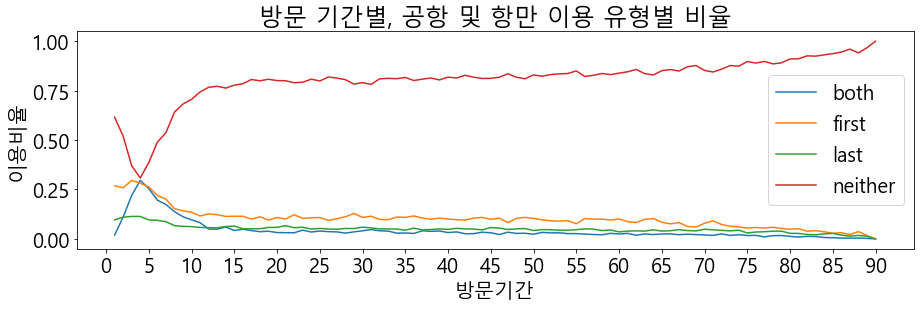

In [397]:
# 공항 이용율
wedgeprops={'width': 0.65, 'edgecolor': 'w', 'linewidth': 5}

columns = ['both', 'first', 'last', 'neither']
values = [[], [], [], []]
period = 90
term = 1
for period in list(range(1, period+1, term)):
    user_df2 = user_df[(period-1 < user_df['period']) & (user_df['period'] <= period)]
    for i in range(4):
        sum = len(user_df2)
        values[i].append(len(user_df2[user_df2[columns[i]]])/sum)

plt.rcParams["figure.figsize"] = (15,4)
for i in list(range(4)):
    plt.plot(list(range(1, period+1, term)), values[i])
    
plt.legend(columns)
plt.title('방문 기간별, 공항 및 항만 이용 유형별 비율')
plt.xlabel("방문기간")
plt.ylabel("이용비율")
plt.xticks(list(range(0, period+1, 5)))
plt.show()

# 4. 결과 출력 

### 4-1) 이용자 유형 분석

In [269]:
print("공항에서 시작하는 이용자")
a = user_df[user_df["first_station"] == "airport"]
b = a["last_station"].value_counts()
print("(harbor->airport) {}(명)".format(b[0]))
print("(harbor->harbor)  {}(명)".format(b[1]))
print("(harbor->other)   {}(명)".format(b[2]))

print("\n항만에서 시작하는 이용자")
a = user_df[user_df["first_station"] == "harbor"]
b = a["last_station"].value_counts()
print("(harbor->airport) {}(명)".format(b[0]))
print("(harbor->harbor)  {}(명)".format(b[1]))
print("(harbor->other)   {}(명)".format(b[2]))

공항에서 시작하는 이용자
(harbor->airport) 130660(명)
(harbor->harbor)  46436(명)
(harbor->other)   463(명)

항만에서 시작하는 이용자
(harbor->airport) 3414(명)
(harbor->harbor)  793(명)
(harbor->other)   560(명)


#### 관관객의 이용기간 별 이용자 수

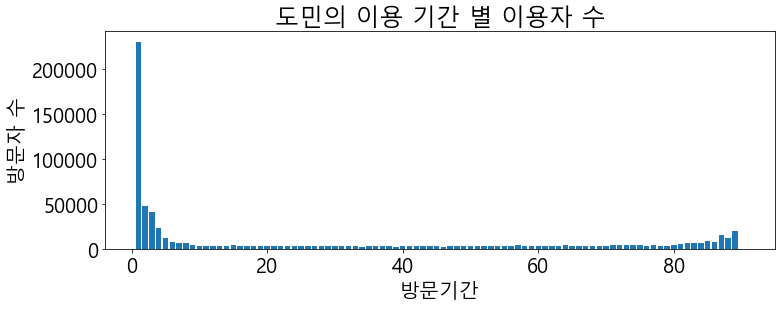

In [272]:
data = user_df[user_df['tourist'] == False]
period_user(plt, data)

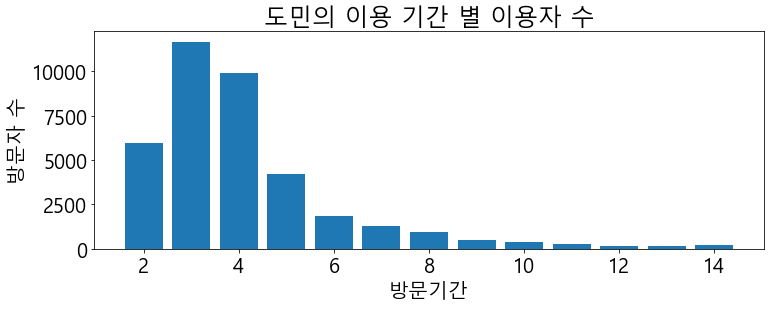

In [273]:
data = user_df[user_df['tourist'] == True]
period_user(plt, data)

In [155]:
i=22
tourist = list(user_infor_df[user_infor_df["tourist"] == 1]["user_id"])
d = usage_df.query('{} == "{}"'.format("user_id", tourist[i]))[selete].sort_values(by = "geton_datetime")
end = d.tail(n=1).iloc[0, 4]
print(type(end))

<class 'float'>


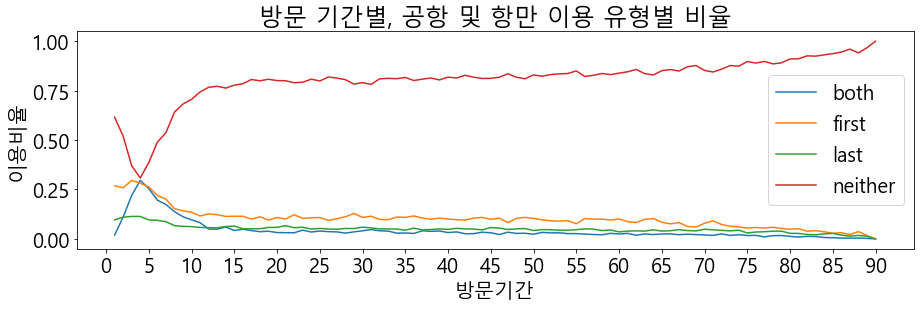

In [396]:
# 공항 이용율
wedgeprops={'width': 0.65, 'edgecolor': 'w', 'linewidth': 5}

columns = ['both', 'first', 'last', 'neither']
values = [[], [], [], []]
period = 90
term = 1
for period in list(range(1, period+1, term)):
    user_df2 = user_df[(period-1 < user_df['period']) & (user_df['period'] <= period)]
    for i in range(4):
        sum = len(user_df2)
        values[i].append(len(user_df2[user_df2[columns[i]]])/sum)

plt.rcParams["figure.figsize"] = (15,4)
for i in list(range(4)):
    plt.plot(list(range(1, period+1, term)), values[i])
    
plt.legend(columns)
plt.title('방문 기간별, 공항 및 항만 이용 유형별 비율')
plt.xlabel("방문기간")
plt.ylabel("이용비율")
plt.xticks(list(range(0, period+1, 5)))
plt.show()

해석
* 공항 또는 항만을 이용한 대중교통 승객은 2~10일 사이에 모여있다.
* both의 경우 관광객 방문기간 통계자료를 따른다.
* last의 경우 both와 first보다 상대적으로 낮은 비율을 보인다.
(보통 집에 공항으로 갈 땐 귀찮아서 택시를 이용하는 듯)

# 추출된 임의의 관광객 이동 패턴 출력 예시

In [353]:
def show_od_pattern(user_df, usage_df, num):
    id = user_df.iloc[num, 0]
    select = ["base_date", "geton_datetime", "geton_stataion_name", "getoff_datetime", "getoff_station_name", "user_count"]
    od_df = usage_df.query('user_id == "{}"'.format(id)).sort_values('geton_datetime')
    return od_df[select]

In [131]:
id = 'e3de073570ab60d5c20ce911e4808be2d190302b043a08446dfb43873749772d'
select = ["base_date", "geton_datetime", "geton_stataion_name", "getoff_datetime", "getoff_station_name", "user_count"]
od_df = usage_df.query('user_id == "{}"'.format(id)).sort_values('geton_datetime')
od_df["base_date", "geton_datetime", "geton_stataion_name", "getoff_datetime", "getoff_station_name", "user_count"]

,user_id,base_date,route_id,route_name,route_no,geton_datetime,geton_station_id,geton_stataion_name,geton_station_longitude,geton_station_latitude,getoff_datetime,getoff_station_id,getoff_station_name,getoff_station_longitude,getoff_station_latitude,user_type,user_count,input_date
1215,e3de073570ab60d5c20ce911e4808be2d190302b043a08...,20190601,23610000,365-21(제주대학교~제주한라대학교(종점)),365-21,2019-06-01 15:38:18,1355,제주국제공항(신제주방면),126.49275,33.50610,2019-06-01 15:43:25,321.0,제주도청신제주로터리,126.49647,33.49110,일반,1,20190601
1213,e3de073570ab60d5c20ce911e4808be2d190302b043a08...,20190601,23620000,365-22(제주한라대학교~제주대학교),365-22,2019-06-01 15:52:17,320,제주도청신제주로터리,126.49678,33.49143,2019-06-01 16:08:04,323.0,서문시장,126.51845,33.51203,일반,1,20190601
1214,e3de073570ab60d5c20ce911e4808be2d190302b043a08...,20190601,23020000,312-1(한라수목원~신사동(종점)),312-1,2019-06-01 17:49:36,282,중앙로(동문시장),126.52457,33.51168,2019-06-01 18:20:33,219.0,원당분화원,126.59493,33.52107,일반,1,20190601
1212,e3de073570ab60d5c20ce911e4808be2d190302b043a08...,20190601,28580000,201-21(제주버스터미널(가상정류소)~서귀포버스터미널),201-21,2019-06-01 18:23:30,219,원당분화원,126.59493,33.52107,2019-06-01 19:35:11,2613.0,고성리구성산농협,126.91496,33.44798,일반,1,20190603
226723,e3de073570ab60d5c20ce911e4808be2d190302b043a08...,20190602,31310000,211-6(성산항~제주버스터미널(종점)),211-6,2019-06-02 16:09:46,2215,고성리장만이동산,126.90047,33.44555,2019-06-02 17:07:12,2969.0,제주버스터미널(종점),126.51632,33.49919,일반,1,20190602
226724,e3de073570ab60d5c20ce911e4808be2d190302b043a08...,20190602,21410000,151-1(제주버스터미널(가상정류소)~모슬포남항여객선터미널(운진항)),151-1,2019-06-02 17:28:00,1564,제주시외버스터미널,126.51479,33.49946,2019-06-02 18:01:33,432.0,정존마을,126.47352,33.48181,일반,1,20190604
226722,e3de073570ab60d5c20ce911e4808be2d190302b043a08...,20190602,23620000,365-22(제주한라대학교~제주대학교),365-22,2019-06-02 20:03:15,358,한라병원,126.48600,33.48963,2019-06-02 20:32:42,304.0,용문사거리,126.51023,33.50866,일반,1,20190602
405456,e3de073570ab60d5c20ce911e4808be2d190302b043a08...,20190603,23610000,365-21(제주대학교~제주한라대학교(종점)),365-21,2019-06-03 11:34:31,305,용문사거리,126.51005,33.50881,2019-06-03 11:40:29,1355.0,제주국제공항(신제주방면),126.49275,33.50610,일반,1,20190603
